# Working with raster data in python

I've not been working with raster data too much recently, so what better time to brush up and take a look at tools available to work with the format. For this brief , we will be working with [rasterio](https://rasterio.readthedocs.io/en/latest/intro.html) and the open source spatial library that needs no introduction: [gdal](https://gdal.org/index.html).


I will assume gdal is already installed, but if not head to [here](https://gdal.org/download.html) and find the relevant link for your operating system.

To start with, let's set up a python venv `python -m venv geoenv` 
Note: This is using linux so if you're on windows the syntax will be different. 

Next, activate the venv `source geoenv/bin/activate` and install rasterio using `pip install rasterio`. We will also be using matplotlib for plotting the data: `pip install matplotlib`.


If you're after some open data sets to play with, try some of these out:
* [LIDAR Composite DTM 2017 - 50cm](https://data.gov.uk/dataset/5f6f7d5b-3f4c-4476-bfb8-cda490c9cf0e/lidar-composite-dtm-2017-50cm)
* [LIDAR Composite DTM 2019 – 10m](https://data.gov.uk/dataset/8311f42d-bddd-4cd4-98a3-e543de5be4cb/lidar-composite-dtm-2019-10m)
* [OS Terrain 50](https://osdatahub.os.uk/downloads/open/Terrain50)

For this demo I'll be using the Terrain 50 as it's a smaller dataset for quicker analysis.


To start off, let's import our rasterio

In [1]:
%matplotlib inline

import rasterio

Now the first step involves reading in the data, this is incredibly simple, simply assign a variable using the `rasterio.open()` method.

In [2]:
src = rasterio.open('data/data/sp/SP36.asc', 'r')

the `open` command returns a rasterio DatasetReader object. If you wish to view the metadata of the object, you can do using the `meta` property. This will return a dictionary object with the following information: 

In [3]:
src.meta

{'driver': 'AAIGrid',
 'dtype': 'float32',
 'nodata': None,
 'width': 200,
 'height': 200,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["British_National_Grid",GEOGCS["GCS_OSGB_1936",DATUM["OSGB_1936",SPHEROID["Airy_1830",6377563.396,299.3249646]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",400000],PARAMETER["False_Northing",-100000],PARAMETER["Central_Meridian",-2],PARAMETER["Scale_Factor",0.999601272],PARAMETER["Latitude_Of_Origin",49],UNIT["Meter",1]]'),
 'transform': Affine(50.0, 0.0, 430000.0,
        0.0, -50.0, 270000.0)}

The above tells us the raster has a width and height of 200 pixels, has a single band and is projected as British National Grid. The final value, `transform`, informs us a pixel is of height and width 50m and the raster has the point of origin at 430000 270000. 

Now let's plot the raster using `pyplot`

<AxesSubplot:>

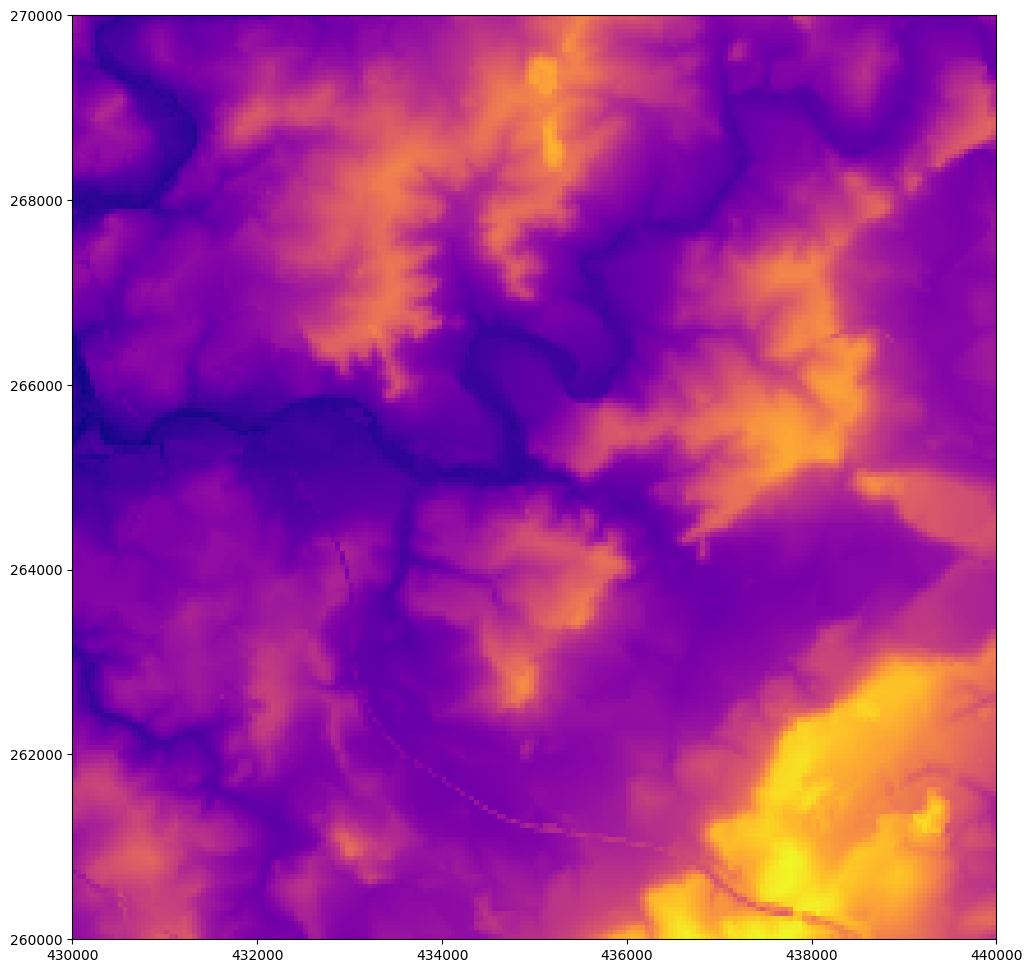

In [4]:
from matplotlib import pyplot
from rasterio.plot import show

fig, ax = pyplot.subplots(1, figsize=(12, 12))
show((src), cmap='plasma', interpolation='none', ax=ax)

Now as we're using a coarse 50m resolution raster over a fairly small geographic area, it looks a little ropey, let's use the merge function to form a mosaic. First, we need to put together a list of files we want to merge.

In [5]:
import os

file_paths = []

path = '/home/pi/data/data/sp/'

for folder, subs, files in os.walk(path):
    for filename in files:
        if filename.endswith('.asc'):
            src = rasterio.open(os.path.join(path,filename))
            file_paths.append(src)

The above uses the `os.walk()` method to iterate over the folder containing the files for the ST 100km grid square, it then appends any .asc files to the list we assigned at the start. Next we import the and assign the `merge` method. Note that `merge` returns two objects - a numpy array of rasters and `affine.Affine()` transformation object. For the purpose of this we only need to worry about the former.

In [6]:
from rasterio.merge import merge

mosaic, out_trans = merge(file_paths)

Then plot as before - now this looks better.

<AxesSubplot:>

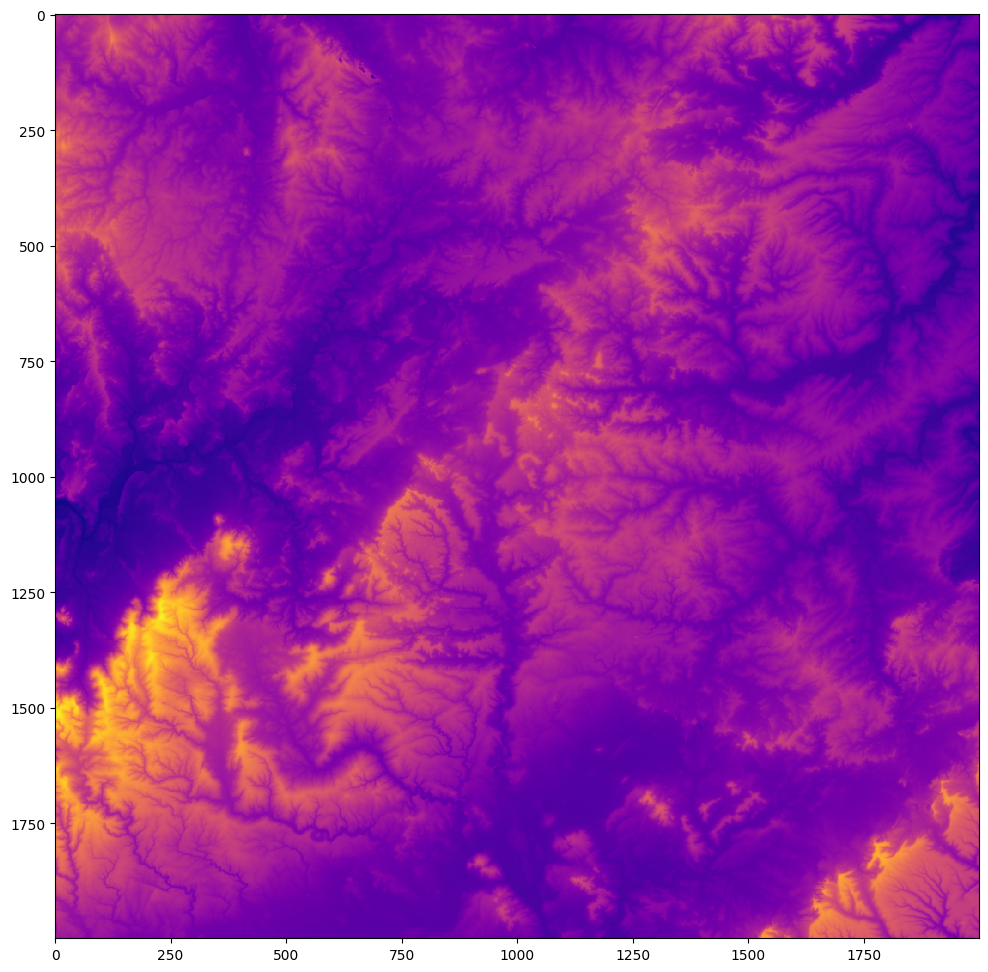

In [7]:
from rasterio.plot import show

fig, ax = pyplot.subplots(1, figsize=(12, 12))
show((mosaic), cmap='plasma', interpolation='none', ax=ax)

So how about exporting this file as a tif to enable us to paly around with gdal library a bit? Easy with rasterio.

In [8]:
out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "crs": "+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs"
                })